In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm


from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from hurst import compute_Hc
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA
from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from warnings import filterwarnings

filterwarnings('ignore')


In [2]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

In [177]:
class pair_select:

    def __init__ (self, price_df, etf_info, formation_start_date, formation_end_date, trade_start_date, trade_end_date):
        self.price_df               = price_df                  # Price History
        self.etf_info               = etf_info                  # etf_info
        self.formation_start_date   = formation_start_date      
        self.formation_end_date     = formation_end_date        
        self.trade_start_date       = trade_start_date           
        self.trade_end_date         = trade_end_date        
    
        _, self.close_df_test, self.rtn_df_test, self.low_volume_etf_test \
            = self.preprocessing(trade_start_date, trade_end_date)

        self.preprocessing(self.formation_start_date, self.formation_end_date)
        self.get_clustering()
        self.get_pair_selection()

    def preprocessing (self, start_date, end_date):
        '''For formation, input formation period'''
        
        formation = self.price_df[(self.price_df.Date >= start_date) & (self.price_df.Date < end_date)].set_index('Date')
        #formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())
        formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())[0:50]
        
        close_df = pd.DataFrame(index = formation.index.unique())

        for x in tqdm(formation_etf_list):
            tmp = formation['Close'][formation.tic == x]
            close_df = pd.concat([close_df, tmp], axis=1)

        close_df.columns = formation_etf_list
        #rtn_df = close_df.pct_change()[1:] # return을 pct로?
        rtn_df = np.log(close_df).diff()[1:]

        etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')
        low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

        self.formation       = formation
        self.close_df        = close_df
        self.rtn_df          = rtn_df
        self.low_volume_etf  = low_volume_etf

        return formation, close_df, rtn_df, low_volume_etf

    def get_pca_return(self, pc_selecting_threshold=0.9):

        rtn_df_scaled = pd.DataFrame(StandardScaler().fit_transform(self.rtn_df))
        pca = PCA()
        pca.fit(rtn_df_scaled)
        cumsum_eigen_value = np.cumsum(pca.explained_variance_ratio_)
        pca_components = pca.components_[:np.where(cumsum_eigen_value >= pc_selecting_threshold)[0][0]]

        pc_rtn = pd.DataFrame(data=pca_components.T, index=self.rtn_df.columns)
        pc_rtn = pc_rtn.add_prefix("P")

        self.pc_rtn = pc_rtn

        return pc_rtn        

    def get_clustering(self, pca_rtn=None, eps=1.8, min_samples=4, cluster_size_limit=100, cluster_member_counts=100):

        if pca_rtn is not None:
            pc_rtn = pca_rtn
        else:
            pc_rtn = self.get_pca_return()        

        data = StandardScaler().fit_transform(pc_rtn)
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        clf.fit(data)

        labels = clf.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print("Clusters discovered: %d" % n_clusters_)

        clustered = clf.labels_
        clustered_series = pd.Series(index = pc_rtn.index, data = clustered.flatten())
        clustered_series_all = pd.Series(index = pc_rtn.index, data = clustered.flatten())
        clustered_series = clustered_series[clustered_series != -1]

        counts = clustered_series.value_counts()
        ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
        print("Clusters formed: %d" % len(ticker_count_reduced))
        print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())


        # 클러스터링 안에 etf가 너무 많으면 pair selection 시간 너무 많이 걸림. 너무 많은 etf 포함하고 있는 clustering 제외하기
        # cluster_memeber_counts 파라미터 조정 필요. 너무 크면 돌리는데 시간이 오래 걸리고, 너무 작으면 페어가 안뽑힐 수도 있음. 
        counts = clustered_series.value_counts()
        clusters_viz_list = list(counts[(counts < cluster_member_counts) & (counts > 1)].index)[::-1]
        print('final_clusters index : ', clusters_viz_list)

        self.clusters_viz_list = clusters_viz_list
        self.clustered_series  = clustered_series

        return clusters_viz_list, clustered_series

    def get_pair_selection(self, inverse_threshold=0.99,\
                                 coint_pvalue_threshold=0.05,\
                                 hurst_threshold=0.5,\
                                 half_life_threshold=30,\
                                 mean_reverting_freq=12):

        '''pair with list, short_pair with dict'''
        selected_pair = []
        for i in tqdm(range(len(self.clusters_viz_list))):
            test_list = list(self.clustered_series[self.clustered_series == self.clusters_viz_list[i]].index)

            # 1. 거래량 10분위 이하 제거
            vol_screened_test_list = []
            for x in test_list:
                if (x in self.low_volume_etf) == False:
                    vol_screened_test_list.append(x)       
                    
            # 2. corr -0.99 보다 작은 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부
            short_avail_test_list = []
            short_pair = {}
            for x in vol_screened_test_list:
                if self.rtn_df.corr()[x].min() < inverse_threshold:
                    short_avail_test_list.append(x)
                    short_pair[x] = self.rtn_df.corr()[x].idxmin()
                    
            # 3. Cointegration - pvalue 0.05 이하인 pair sorting
            log_price_data = np.log(self.close_df[short_avail_test_list])
            comb = list(combinations(short_avail_test_list, 2))
            eg_pvalue = {}

            for x in tqdm(comb):
                score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
                eg_pvalue[x] = pvalue

            possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= coint_pvalue_threshold]

            # 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정
            spread_df = pd.DataFrame(index = log_price_data.index)

            for x in possible_pair:
                spread_df[x] = self.close_df[x[0]] - self.close_df[x[1]]
            
            hurst_screened_list = []

            for cnd in possible_pair:
                if compute_Hc(spread_df[cnd])[0] <= hurst_threshold:
                    hurst_screened_list.append(cnd)

            spread_df = spread_df[hurst_screened_list]

            # 5. Half life가 trading period 안에 들어오는 종목 스크리닝
            spread_df_lag = spread_df.shift(1)
            spread_df_diff = spread_df - spread_df_lag

            hl_screened_list = []

            for i in range(len(hurst_screened_list)):

                X = sm.add_constant(spread_df_lag.iloc[1:,i])
                model = sm.OLS(spread_df_diff.iloc[1:,i], X)
                result = model.fit()
                lamda = result.params[1]
                HL = -np.log(2) / lamda

            # trading period 고려
                if (HL <= half_life_threshold) & (HL >= 1):
                    hl_screened_list.append(hurst_screened_list[i])

            spread_df = spread_df[hl_screened_list]

            # 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝
            freq_screened_list = []

            for j in range(len(spread_df.columns)):

                cnt = 0

                for i in range(len(spread_df.index)):

                    if i == len(spread_df.index) -1:
                        break

                    elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
                        if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                            cnt += 1

                    else:
                        if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                            cnt += 1
                
                if cnt >= mean_reverting_freq:
                    freq_screened_list.append(hl_screened_list[j])

            selected_pair.append(freq_screened_list)

        self.selected_pair = selected_pair[0]
        self.short_pair = short_pair

        return selected_pair[0], short_pair

    #def 


In [190]:
start_date = '2014-01-01'
end_date = '2015-12-31'

test_start_date = '2016-01-01'
test_end_date = '2017-12-31'

ps = pair_select(price_df, etf_info, start_date, end_date, test_start_date, test_end_date)
ps.selected_pair, ps.short_pair

100%|██████████| 50/50 [00:00<00:00, 73.30it/s]


Clusters discovered: 1
Clusters formed: 1
Pairs to evaluate: 702
final_clusters index :  [0]


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


([('MOO', 'CSD'), ('RYF', 'FVD'), ('RWJ', 'MIDU')],
 {'IVE': 'SPXS',
  'RYF': 'SPXS',
  'QQXT': 'PSQ',
  'RWJ': 'SPXS',
  'FDD': 'SPXS',
  'VFH': 'SPXS',
  'SCHC': 'SPXS',
  'DWM': 'SPXS',
  'VXUS': 'EEV',
  'IVOG': 'SPXS',
  'RWL': 'SPXS',
  'FXO': 'SPXS',
  'MOO': 'SPXS',
  'RZG': 'SPXS',
  'CSD': 'SPXS',
  'RPV': 'SPXS',
  'DWAS': 'QID',
  'KXI': 'DOG',
  'FXD': 'SPXS',
  'QDF': 'SPXS',
  'MIDU': 'SPXS',
  'VUG': 'SPXS',
  'ONEQ': 'QID',
  'FVD': 'SPXS',
  'DLN': 'SPXS',
  'ROM': 'QID',
  'DIM': 'SPXS'})

In [191]:
ps.selected_pair

[('MOO', 'CSD'), ('RYF', 'FVD'), ('RWJ', 'MIDU')]

In [192]:
short_list = {}
selected_pair_etf = []
for i in range(len(ps.selected_pair)):
    selected_pair_etf.append(ps.selected_pair[i][0])
    selected_pair_etf.append(ps.selected_pair[i][1])
    short_list[ps.selected_pair[i][0]] = ps.rtn_df.corr()[ps.selected_pair[i][0]].idxmin()
    short_list[ps.selected_pair[i][1]] = ps.rtn_df.corr()[ps.selected_pair[i][1]].idxmin()
    

In [193]:
ps.close_df

,IVE,SIL,ROBO,FKU,UBR,ERTH,SPXS,RYF,FPA,QQXT,...,PSI,EEV,VUG,ONEQ,FVD,DLN,EIDO,PPH,ROM,DIM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,84.720001,34.860001,27.000000,42.560001,125.940002,31.389999,1706.5,27.458101,27.500000,34.529999,...,18.570000,108.099998,92.230003,16.333000,21.110001,32.985001,22.200001,52.590000,3.360938,57.849998
2014-01-03,84.809998,34.830002,26.990000,42.830002,127.500000,31.540001,1708.5,27.667599,27.530001,34.520000,...,18.610001,108.650002,91.970001,16.253000,21.120001,32.970001,22.020000,52.880001,3.363125,58.200001
2014-01-06,84.680000,34.590000,26.940001,42.910000,127.500000,31.490000,1722.5,27.625698,27.350000,34.270000,...,18.540001,110.750000,91.580002,16.179001,21.020000,32.904999,21.760000,52.740002,3.326250,58.139999
2014-01-07,85.080002,34.529999,27.030001,43.000000,124.500000,31.750000,1691.5,27.730448,27.600000,34.610001,...,18.610001,109.800003,92.279999,16.347000,21.139999,33.055000,21.680000,53.330002,3.398438,58.560001
2014-01-08,84.949997,34.049999,27.180000,43.099998,121.559998,31.650000,1690.5,27.751396,27.559999,34.610001,...,18.570000,110.449997,92.440002,16.391001,21.049999,32.959999,21.830000,53.860001,3.407188,58.490002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-23,90.320000,19.049999,24.420000,40.340000,27.500000,29.620001,822.5,30.356146,28.059999,41.680000,...,25.719999,112.949997,107.160004,19.819000,24.090000,36.025002,21.150000,66.220001,4.973125,55.880001
2015-12-24,89.510002,19.430000,24.414000,40.599998,27.549999,29.809999,827.0,30.370111,27.980000,41.750000,...,25.920000,113.800003,107.029999,19.851000,24.090000,35.924999,20.969999,66.150002,4.974375,55.570000
2015-12-28,89.089996,18.770000,24.419001,40.139999,27.610001,29.500000,831.5,30.307262,27.580000,41.529999,...,25.670000,115.400002,106.980003,19.752001,24.070000,35.810001,21.200001,65.709999,4.970000,55.610001


In [205]:

# 모델 트레이닝을 위한 포메이션 기간동안의 페어 가격 추출
training_set_price = pd.DataFrame(index=ps.close_df.index)
for i in range(len(ps.selected_pair)):
    training_set_price = pd.concat([training_set_price, ps.close_df[list(ps.selected_pair[i])]], axis=1)

training_set_inverse_price = ps.close_df[[short_list[x] for x in training_set_price.columns]]

# 페아별 z-score 뽑기
for i in range(len(ps.selected_pair)):

    print("pairs = (" + str(ps.selected_pair[i]) + ")\n")

    a = training_set_price.iloc[:,2*i].to_numpy()
    b = training_set_price.iloc[:,2*i+1].to_numpy()

    spread_func = create_spread_function(a, b, 0, -1, alg='lr')
    x = np.arange(len(a))
    z_score_history = np.zeros((len(a)))

    for j in range(len(a)):
        (spread, z_score_history[j]) = spread_func(a[j], b[j])

# 패어별로 z-score time series 뽑기
z_score_history_list = []

for i in range(len(ps.selected_pair)):

    price_history = training_set_price.to_numpy()[:,2*i:2*i+2].T
    z_score_history = gen_z_score_history(price_history[0], price_history[1], 20, 20).reshape(1, -1)
    z_score_history_list.append(z_score_history)

z_score_history_list = np.array(z_score_history_list).reshape(len(ps.selected_pair), -1)
z_score_list = z_score_history_list[:len(ps.selected_pair),:]

stock_price_list = training_set_price.T.to_numpy()[:,20:]
inverse_price_list = training_set_inverse_price.T.to_numpy()[:,20:]

# best threshold 찾기
best_threshold = {}
for i in range(len(ps.selected_pair)):
    best_threshold[ps.selected_pair[i]] = get_best_threshold(z_score_list[i].reshape(1,-1),stock_price_list, inverse_price_list)

pairs = (('MOO', 'CSD'))

pairs = (('RYF', 'FVD'))

pairs = (('RWJ', 'MIDU'))

best_earning_ratio is:  1.0776140540390016
best_earning_ratio is:  1.2177445214958191
best_earning_ratio is:  1.1683708806228639


# 위의 Pair Selection으로 아래 trade 진행

In [204]:

def create_spread_function(pair_a, pair_b, start_date, end_date, alg='log'):

    def log_spread_func(pair_a, pair_b):
        
        spread = np.log(pair_b) - w_avg * np.log(pair_a)
        z_score = spread/w_std

        return (spread, z_score)

    def lr_spread_func(pair_a, pair_b):
        pair_a, pair_b = np.log(pair_a), np.log(pair_b)
        pair_a = pair_a * np.ones((1,1))
        poly = PolynomialFeatures(degree=best_degree)
        pair_a = poly.fit_transform(pair_a)

        spread = pair_b - model.predict(pair_a)
        z_score = spread / spread_std

        return (spread, z_score)

    target_a = np.log(pair_a[start_date:end_date])
    target_b = np.log(pair_b[start_date:end_date])

    # holding_period = end_date - start_date

    if alg == 'log':
        
        w_list = target_b / target_a
        w_avg = np.average(w_list)
        w_std = np.std(w_list)

        return log_spread_func
    
    elif alg == 'lr':

        min_cv_n = float('inf')
        best_degree = 0
        total_len = target_a.size

        permute_order = np.random.permutation(total_len)
        target_a = target_a[permute_order]
        target_b = target_b[permute_order]

        train_num = int(target_a.size/3*2)

        train_a = target_a[:train_num]
        train_b = target_b[:train_num]
        val_a = target_a[train_num:]
        val_b = target_b[train_num:]

        train_a = train_a.reshape(-1,1)
        val_a = val_a.reshape(-1,1)

        for degree in range(1,10,1):

            poly = PolynomialFeatures(degree=degree)
            poly_train_a = poly.fit_transform(train_a)
            poly_val_a = poly.fit_transform(val_a)

            model = linear_model.LassoCV(cv=5)
            model.fit(poly_train_a, train_b)
            
            mse = np.average((val_b - model.predict(poly_val_a))**2)

            if mse < min_cv_n:
                best_degree = degree
                min_cv_n = mse

        if best_degree == 0:
            print("error!")

        poly = PolynomialFeatures(degree= best_degree)
        poly_train_a = poly.fit_transform(train_a)
        model = linear_model.LassoCV(cv=5)
        model.fit(poly_train_a, train_b)

        b_pred = model.predict(poly_train_a)
        spread = train_b - b_pred
        spread_std = np.std(spread)

        return lr_spread_func

def gen_z_score_history(a, b, windows_width, spread_func_update_period):

    T = a.shape[0]
    z_score_list = np.zeros((T-windows_width))

    for t in range(T-windows_width):

        if t % spread_func_update_period==0:
            spread_func = create_spread_function(a,b,t,t+windows_width, 'lr')
        
        _, z_score = spread_func(a[t],b[t])
        z_score_list[t] = z_score

    return z_score_list

def get_best_threshold(z_score_list, stock_price_list, inverse_price_list, initial_money=1000000):
    stop_loss_candi = [1, 1.5, 2, 3]
    buy_z_candi = np.round(np.linspace(0, 2, 21), 1)
    sell_z_candi = np.round(np.linspace(0, 2, 21), 1)
    grid_search_result = {}
    for x in stop_loss_candi:
        for y in buy_z_candi:
            for z in sell_z_candi:
                stop_loss = x
                buy_z = y
                sell_z = z
                BT = pair_trade_ban(z_score_list, total_money=initial_money, stop_loss=stop_loss, buy_z=buy_z, sell_z=sell_z)
                asset_per_pair, stock_a_vol_list, inverse_a_vol_list, stock_b_vol_list, inverse_b_vol_list = BT.pair_trade_ban(z_score_list, stock_price_list, inverse_price_list)
                total_asset = np.sum(asset_per_pair, axis=0)
                total_earning_ratio = total_asset[-1] / initial_money
                grid_search_result[(x,y,z)] = total_earning_ratio

    best_param = max(grid_search_result, key=grid_search_result.get)
    best_earning_ratio = grid_search_result[best_param]

    print('best_earning_ratio is: ', best_earning_ratio)

    return best_param

# -----------------------------------------------------------------------------------------------

class pair_trade_ban:

    def __init__(self, z_score_list, stop_loss, buy_z, sell_z, total_money=1000000):
        
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1]
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z
        
        self.inverse_price = np.zeros((2*self.pairs_num))
        self.total_stock = np.zeros((2*self.pairs_num))
        self.total_inverse = np.zeros((2*self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * np.ones((self.pairs_num))
    
    def trade_decision(self, z_score, pairs_num):
        
        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2*(pairs_num)]
        total_inverse = self.total_inverse[2*(pairs_num)]
        stock, inverse = 0, 0 

        # 스탑로스 컷에 걸릴 때는 다 팔기
        if z_score >= stop_loss or z_score <= -1 * stop_loss:
            stock, inverse = -2, -2
        
        # buy threshold 이상이면서 해당 etf 보유하고 있지 않으면 매수
        elif z_score >= buy_z and total_stock==0:
            stock, inverse = 1, 0

        # sell threshold 이하이면서, 해당 etf 보유하고 있으면 etf 팔기
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # -buy threshold 이하로 떨어지는데, 인버스 etf 보유하고 있지 않을 땐 inverse etf 사기
        elif z_score <= -1 * buy_z and total_inverse==0:
            stock, inverse = 0, 1
        
        # -sell threshold 이상으로 올라가는데, 인버스 etf를 보유하고 있으면 inverse etf 팔기
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1 

        return stock, inverse
    
    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_stock_price, current_inverse_price):

        trade_stock_vol = 0
        trade_inverse_vol = 0

        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_stock_price)

        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]
        
        elif inv_signal > 0:
            trade_inverse_vol = int(money_for_stock/current_inverse_price)

        return trade_stock_vol, trade_inverse_vol


    def cal_result(self, stock_num, stock_vol, inverse_vol, current_stock_price, current_inverse_price):

        # if self.total_inverse[stock_num] > 0:
        #     change_ratio = (current_price - prev_price) / prev_price
        #     self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]


        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_stock_price

        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_stock_price
        
            # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_inverse_price
            # self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_inverse_price
            # self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            # self.inverse_price[stock_num] = 0

        # total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
        #                 self.total_stock[stock_num] * current_price) 

        total_asset = (self.total_inverse[stock_num] * current_inverse_price +
                        self.total_stock[stock_num] * current_stock_price)

        return total_asset

    def pair_trade_ban(self, z_score_list, stock_price_list, inverse_price_list):

        total_asset = np.zeros((self.pairs_num, self.total_time))
        stock_a_vol_list = []
        inverse_a_vol_list = []
        stock_b_vol_list = []
        inverse_b_vol_list = []

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2* pair_num
                stock_b_num = 2* pair_num + 1
                z_score = z_score_list[pair_num]

                # 매수매입 시그널
                stock_a, inverse_a = self.trade_decision(z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # 매수매입 수량 결정
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(stock_a_num, stock_a, inverse_a, stock_price_list[stock_a_num][t], inverse_price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(stock_b_num, stock_b, inverse_b, stock_price_list[stock_b_num][t], inverse_price_list[stock_b_num][t])
                stock_a_vol_list.append(stock_a_vol)
                inverse_a_vol_list.append(inverse_a_vol)
                stock_b_vol_list.append(stock_b_vol)
                inverse_b_vol_list.append(inverse_b_vol)

                # 투자 결과
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, inverse_a_vol, stock_price_list[stock_a_num][t], inverse_price_list[stock_a_num][t])
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol, inverse_b_vol, stock_price_list[stock_b_num][t], inverse_price_list[stock_b_num][t])
                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset, stock_a_vol_list, inverse_a_vol_list, stock_b_vol_list, inverse_b_vol_list

    
    def create_spread_function(pair_a, pair_b, start_date, end_date, alg='log'):

        def log_spread_func(pair_a, pair_b):
            
            spread = np.log(pair_b) - w_avg * np.log(pair_a)
            z_score = spread/w_std

            return (spread, z_score)

        def lr_spread_func(pair_a, pair_b):
            pair_a, pair_b = np.log(pair_a), np.log(pair_b)
            pair_a = pair_a * np.ones((1,1))
            poly = PolynomialFeatures(degree=best_degree)
            pair_a = poly.fit_transform(pair_a)

            spread = pair_b - model.predict(pair_a)
            z_score = spread / spread_std

            return (spread, z_score)

        target_a = np.log(pair_a[start_date:end_date])
        target_b = np.log(pair_b[start_date:end_date])

        # holding_period = end_date - start_date

        if alg == 'log':
            
            w_list = target_b / target_a
            w_avg = np.average(w_list)
            w_std = np.std(w_list)

            return log_spread_func
        
        elif alg == 'lr':

            min_cv_n = float('inf')
            best_degree = 0
            total_len = target_a.size

            permute_order = np.random.permutation(total_len)
            target_a = target_a[permute_order]
            target_b = target_b[permute_order]

            train_num = int(target_a.size/3*2)

            train_a = target_a[:train_num]
            train_b = target_b[:train_num]
            val_a = target_a[train_num:]
            val_b = target_b[train_num:]

            train_a = train_a.reshape(-1,1)
            val_a = val_a.reshape(-1,1)

            for degree in range(1,10,1):

                poly = PolynomialFeatures(degree=degree)
                poly_train_a = poly.fit_transform(train_a)
                poly_val_a = poly.fit_transform(val_a)

                model = linear_model.LassoCV(cv=5)
                model.fit(poly_train_a, train_b)
                
                mse = np.average((val_b - model.predict(poly_val_a))**2)

                if mse < min_cv_n:
                    best_degree = degree
                    min_cv_n = mse

            if best_degree == 0:
                print("error!")

            poly = PolynomialFeatures(degree= best_degree)
            poly_train_a = poly.fit_transform(train_a)
            model = linear_model.LassoCV(cv=5)
            model.fit(poly_train_a, train_b)

            b_pred = model.predict(poly_train_a)
            spread = train_b - b_pred
            spread_std = np.std(spread)

            return lr_spread_func

    def gen_z_score_history(a, b, windows_width, spread_func_update_period):

        T = a.shape[0]
        z_score_list = np.zeros((T-windows_width))

        for t in range(T-windows_width):

            if t % spread_func_update_period==0:
                spread_func = create_spread_function(a,b,t,t+windows_width, 'lr')
            
            _, z_score = spread_func(a[t],b[t])
            z_score_list[t] = z_score

        return z_score_list

    def get_best_threshold(z_score_list, stock_price_list, inverse_price_list, initial_money=1000000):
        stop_loss_candi = [1, 1.5, 2, 3]
        buy_z_candi = np.round(np.linspace(0, 2, 21), 1)
        sell_z_candi = np.round(np.linspace(0, 2, 21), 1)
        grid_search_result = {}
        for x in stop_loss_candi:
            for y in buy_z_candi:
                for z in sell_z_candi:
                    stop_loss = x
                    buy_z = y
                    sell_z = z
                    BT = pair_trade_ban(z_score_list, total_money=initial_money, stop_loss=stop_loss, buy_z=buy_z, sell_z=sell_z)
                    asset_per_pair, stock_a_vol_list, inverse_a_vol_list, stock_b_vol_list, inverse_b_vol_list = BT.pair_trade_ban(z_score_list, stock_price_list, inverse_price_list)
                    total_asset = np.sum(asset_per_pair, axis=0)
                    total_earning_ratio = total_asset[-1] / initial_money
                    grid_search_result[(x,y,z)] = total_earning_ratio

        best_param = max(grid_search_result, key=grid_search_result.get)
        best_earning_ratio = grid_search_result[best_param]

        print('best_earning_ratio is: ', best_earning_ratio)

        return best_param


In [ ]:
def log_spread_func (pair_a, pair_b, start_date, end_date):
    
    spread = np.log(pair_b) - w_avg * np.log(pair_a)
    z_score = spread/w_std

    return spread, z_score

    

1. 로그 스프레드 만들고, or lr 스프레드 만들고
2. z 스코어를 만들고
3. 스탑로스 기준 만들고
4. 거래시 볼륨 찾고


In [120]:
a.Kelly_Cal(('SCHK', 'SPXS'), '2021-01-01', '2022-01-01')

ValueError: zero-size array to reduction operation maximum which has no identity

# 페어 뽑히고

In [89]:
tmp = a.selected_pair[0]
tmp[0], tmp[1]

('IQLT', 'FPA')

In [110]:
def Kelly_Cal (self, pair_tuple, enter, close):

    spread = self.rtn_df[pair_tuple[0]].loc[enter:close] - self.rtn_df[pair_tuple[1]].loc[enter:close]

    p_value= coint(self.rtn_df[pair_tuple[0]].loc[enter:close], self.rtn_df[pair_tuple[1]].loc[enter:close], method='aeg')[1]

    SD = spread.std()

    hurst = compute_Hc(spread)[0]

    win = np.exp( 1.5 * SD - 0.5 * SD) - 1 #진입 청산 기준
    loss = 1 - np.exp( 1.5*SD - np.nanpercentile(np.abs(spread),99))

    if p_value <= 0.02 and hurst<= 0.3:
        win_rate = 0.9
    elif p_value <= 0.02 or hurst<= 0.3:
        win_rate = 0.7
    else:
        win_rate = 0.5

    loss_rate = 1 - win_rate
    Kelly = win_rate/loss - loss_rate/win

    return Kelly

## 포지션 계산

In [ ]:
enter=[1.5, 1.02]
close=[0.5, 1]

spread = a.rtn_df[tmp[0]] - a.rtn_df[tmp[1]]


## 시그널 찾기

In [105]:
enter=[1.5, 1.02]
close=[0.5, 1]

spread = a.rtn_df[tmp[0]] - a.rtn_df[tmp[1]]
SD = spread.std()

open_cut = SD * enter[0]
close_cut = SD * close[0]
loss_cut = SD * np.nanpercentile(np.abs(spread),99)



In [106]:
np.nanpercentile(np.abs(spread),99)

0.033208523897118036

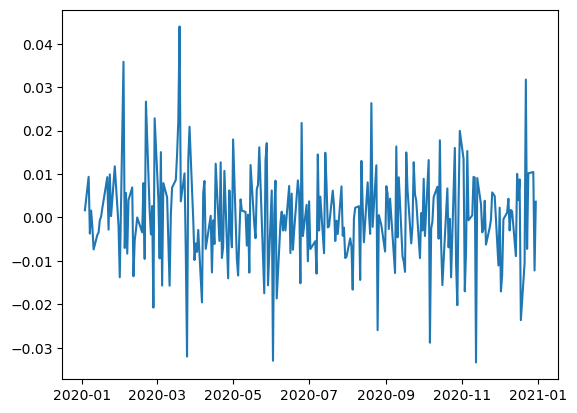

In [100]:
plt.plot(a.rtn_df[tmp[0]] - a.rtn_df[tmp[1]])

In [70]:

dateindex = price_df.index[-1500:]
formation_period = 180
trading_period = 90
train_test_ratio = 0.8
train_num=10
test_num=5

#진입청산 포인트(로그스프레드, 가격비율)
enter=[1.5, 1.02]
close=[0.5, 1]

train_intervals, test_intervals = train_test_split(dateindex, train_test_ratio, formation_period, trading_period, 'sliding', train_num, test_num)


TypeError: Singleton array array(0.8) cannot be considered a valid collection.

In [65]:
a.rtn_df

,IVE,SIL,ROBO,FINX,FKU,ARKW,LFEQ,UBR,ERTH,IQLT,...,EWL,MOO,CCOR,QTUM,RFDA,VMOT,RZG,CSD,RPV,SCHK
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.007147,-0.007619,-0.012041,-0.005854,-0.015879,-0.004427,-0.005920,-0.015738,-0.005395,-0.009277,...,-0.006614,-0.010631,-0.005591,-0.007714,-0.006209,-0.007599,0.002616,0.000396,-0.011872,-0.005983
2020-01-06,0.001618,-0.011383,0.001661,0.000000,-0.001972,0.011369,0.002452,-0.032797,-0.004015,0.004030,...,0.004659,-0.002639,-0.000863,-0.004725,0.001171,0.005006,-0.000337,-0.008141,0.003199,0.002839
2020-01-07,-0.003780,0.008626,0.000948,-0.000979,-0.001481,0.013241,-0.002220,-0.001227,-0.000604,-0.003720,...,-0.004413,-0.000734,-0.002161,0.007751,-0.002772,0.002195,-0.002363,0.000199,-0.001307,-0.001892
2020-01-08,0.002624,-0.037823,0.005670,0.007157,-0.001236,0.015366,0.005094,-0.007396,0.004819,0.003720,...,0.000737,0.005859,0.003383,0.009023,0.004625,0.002786,0.000000,-0.002994,0.000727,0.004534
2020-01-09,0.004461,-0.017677,0.006574,0.006784,-0.000495,0.004744,0.006381,-0.018160,0.000000,0.002781,...,-0.001966,0.001605,0.005267,0.008612,0.004122,0.002897,0.001182,-0.004810,0.003046,0.006638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.007421,0.018180,0.007103,-0.002986,0.026158,-0.008808,0.002591,0.003158,0.005094,0.008552,...,0.004578,0.005357,0.012401,0.001708,-0.000185,0.006383,0.001916,0.012615,0.018975,0.001085
2020-12-24,0.002620,0.009298,-0.001647,0.002986,0.000000,-0.007961,0.002097,0.015076,-0.001070,-0.001420,...,-0.001371,0.005199,0.000000,0.000974,0.002159,-0.003014,-0.002840,-0.000358,-0.001320,0.002436
2020-12-28,0.004430,0.004398,0.000330,-0.005339,0.011906,-0.023933,0.008884,-0.010786,0.005074,0.010462,...,0.015655,-0.001427,0.006668,0.003646,0.007783,-0.004136,-0.000996,-0.009540,0.003297,0.006467


In [55]:
a.selected_pair[1], a.short_pair

([('IQLT', 'FPA'),
  ('RYF', 'EWUS'),
  ('FPA', 'SCHC'),
  ('EWL', 'SCHK'),
  ('FKU', 'RYF'),
  ('RWL', 'VMOT'),
  ('IVE', 'DWM'),
  ('SCHC', 'RFDA'),
  ('FPA', 'RFDA'),
  ('SCHE', 'SCHK'),
  ('VXUS', 'RWL'),
  ('VFH', 'RPV'),
  ('LFEQ', 'EWL'),
  ('SCHE', 'EWL'),
  ('FPA', 'SCHK'),
  ('IQLT', 'RFDA'),
  ('FPA', 'EWL'),
  ('IQLT', 'RWL'),
  ('RFV', 'CSD'),
  ('IQLT', 'SCHK'),
  ('IVE', 'EWUS')],
 {'IVE': 'DOG',
  'ROBO': 'SPXS',
  'FINX': 'SPXS',
  'FKU': 'DOG',
  'ARKW': 'QID',
  'LFEQ': 'SPXS',
  'UBR': 'DOG',
  'ERTH': 'DOG',
  'IQLT': 'DOG',
  'RYF': 'DOG',
  'FPA': 'DOG',
  'QQXT': 'SPXS',
  'ISRA': 'SPXS',
  'RFV': 'DOG',
  'FXN': 'DOG',
  'RWJ': 'DOG',
  'TPOR': 'DOG',
  'EWUS': 'DOG',
  'SDVY': 'DOG',
  'FDD': 'DOG',
  'UJAN': 'SPXS',
  'XITK': 'QID',
  'VFH': 'DOG',
  'SCHE': 'SPXS',
  'SCHC': 'DOG',
  'CHIK': 'QID',
  'DWM': 'DOG',
  'VXUS': 'DOG',
  'CNCR': 'QID',
  'IVOG': 'DOG',
  'UDEC': 'SPXS',
  'IVES': 'QID',
  'RWL': 'DOG',
  'FXO': 'DOG',
  'EWL': 'SPXS',
  'MOO': 'D

In [37]:
a.get_pca_return()

,P0,P1,P2,P3
IVE,-0.153110,0.103558,0.101403,0.120719
SIL,-0.053115,-0.143021,0.210531,-0.705396
ROBO,-0.154990,-0.050135,-0.008521,-0.006979
FINX,-0.149551,-0.122577,0.028713,-0.004587
FKU,-0.136542,0.075016,-0.167483,-0.258515
ARKW,-0.128268,-0.291574,-0.047169,-0.068117
LFEQ,-0.148832,-0.017909,0.135641,0.132834
UBR,-0.135540,0.050530,-0.184804,0.017245
ERTH,-0.151699,-0.010048,-0.041418,-0.098701
IQLT,-0.154441,-0.007319,-0.051160,-0.010860
